### "What just happened???"

Here we take an existing modflow model and setup a very complex parameterization system for arrays and boundary conditions.  All parameters are setup as multpliers: the original inputs from the modflow model are saved in separate files and during the forward run, they are multplied by the parameters to form new model inputs.  the forward run script ("forward_run.py") is also written.  And somewhat meaningful prior covariance matrix is constructed from geostatistical structures with out any additional arguements...oh yeah!

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [2]:
nam_file = "freyberg.nam"
org_model_ws = "Freyberg_transient"
new_model_ws = "pest_setup"
# load the model, change dir and run once to get a hydmod output file and list file
m = flopy.modflow.Modflow.load(nam_file,model_ws=org_model_ws,check=False)
m.change_model_ws("temp",reset_external=True)
m.write_input()
m.run_model()

/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:352: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:605: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:465: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)



changing model workspace...
   temp
FloPy is using the following executable to run the model: /Users/jwhite/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/08/18 15:42:06

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:

 Solving:  Stress period:   111    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   117    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   120    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   121    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   122    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   123    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   222    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   223    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   224    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   225    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   226    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   227    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   228    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   229    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   230    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   233    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   234    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   344    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   345    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   346    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   347    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   348    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   350    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   351    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   352    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   353    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   354    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   355    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   356    Time step:     1    Groundwater-Flow Eqn.

(True, [])

You want some pilot points? We got that...how about one set of recharge multiplier pilot points applied to all stress periods? and sy in layer 1?

In [3]:
pp_props = [["upw.sy",0], ["rch.rech",None]]

You want some constants (uniform value multipliers)?  We got that too....

In [4]:
const_props = []
for iper in range(m.nper):
    const_props.append(["rch.rech",iper])
for k in range(m.nlay):
    const_props.append(["upw.hk",k])
    const_props.append(["upw.ss",k])


You want grid-scale parameter flexibility for hk in all layers? We got that too...and how about sy in layer 1 and vka in layer 2 while we are at it

In [5]:
grid_props = [["upw.sy",0],["upw.vka",1]]
for k in range(m.nlay):
    grid_props.append(["upw.hk",k])
    

Some people like using zones...so we have those too

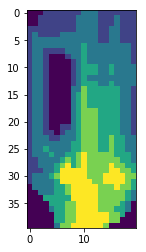

In [6]:
zn_array = np.loadtxt(os.path.join("Freyberg_truth","hk.zones"))
plt.imshow(zn_array)

In [7]:
zone_props = [["upw.ss",0]]
k_zone_dict = {k:zn_array for k in range(m.nlay)}

But wait, boundary conditions are uncertain too...Can we add some parameter to represent that uncertainty?  You know it!

In [8]:
bc_props = [["drn.cond",None]] # drain conductance for all stress periods
for iper in range(m.nper):
    bc_props.append(["drn.elev",iper])
    bc_props.append(["wel.flux",iper])

In [9]:
mfp_boss = pyemu.helpers.PstFromFlopyModel(nam_file,"temp",new_model_ws,
                                          pp_props=pp_props,bc_props=bc_props,
                                          zone_props=zone_props,grid_props=grid_props,
                                          const_props=const_props,k_zone_dict=k_zone_dict,
                                          remove_existing=True,pp_space=4)

2017-08-18 15:42:09.833424 starting: loading flopy model


/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:352: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:605: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/jwhite/Dev/python/flopy/flopy/utils/reference.py:465: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


2017-08-18 15:42:12.335597 finished: loading flopy model took: 0:00:02.502173
2017-08-18 15:42:12.335979 WARNING: removing existing 'new_model_ws

creating model workspace...
   pest_setup

changing model workspace...
   pest_setup
2017-08-18 15:42:12.505455 starting: writing new modflow input files
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to exte

Util2d:rech_296: resetting 'how' to external
Util2d:rech_297: resetting 'how' to external
Util2d:rech_298: resetting 'how' to external
Util2d:rech_299: resetting 'how' to external
Util2d:rech_300: resetting 'how' to external
Util2d:rech_301: resetting 'how' to external
Util2d:rech_302: resetting 'how' to external
Util2d:rech_303: resetting 'how' to external
Util2d:rech_304: resetting 'how' to external
Util2d:rech_305: resetting 'how' to external
Util2d:rech_306: resetting 'how' to external
Util2d:rech_307: resetting 'how' to external
Util2d:rech_308: resetting 'how' to external
Util2d:rech_309: resetting 'how' to external
Util2d:rech_310: resetting 'how' to external
Util2d:rech_311: resetting 'how' to external
Util2d:rech_312: resetting 'how' to external
Util2d:rech_313: resetting 'how' to external
Util2d:rech_314: resetting 'how' to external
Util2d:rech_315: resetting 'how' to external
Util2d:rech_316: resetting 'how' to external
Util2d:rech_317: resetting 'how' to external
Util2d:rec

2017-08-18 15:42:18.836501 finished: writing const tpl:rech23.dat_cn.tpl took: 0:00:00.003581
2017-08-18 15:42:18.839015 starting: writing const tpl:rech24.dat_cn.tpl
2017-08-18 15:42:18.843205 finished: writing const tpl:rech24.dat_cn.tpl took: 0:00:00.004190
2017-08-18 15:42:18.845292 starting: writing const tpl:rech25.dat_cn.tpl
2017-08-18 15:42:18.848851 finished: writing const tpl:rech25.dat_cn.tpl took: 0:00:00.003559
2017-08-18 15:42:18.851052 starting: writing const tpl:rech26.dat_cn.tpl
2017-08-18 15:42:18.854656 finished: writing const tpl:rech26.dat_cn.tpl took: 0:00:00.003604
2017-08-18 15:42:18.856513 starting: writing const tpl:rech27.dat_cn.tpl
2017-08-18 15:42:18.859969 finished: writing const tpl:rech27.dat_cn.tpl took: 0:00:00.003456
2017-08-18 15:42:18.861837 starting: writing const tpl:rech28.dat_cn.tpl
2017-08-18 15:42:18.865307 finished: writing const tpl:rech28.dat_cn.tpl took: 0:00:00.003470
2017-08-18 15:42:18.867186 starting: writing const tpl:rech29.dat_cn.tp

2017-08-18 15:42:19.241371 starting: writing const tpl:rech94.dat_cn.tpl
2017-08-18 15:42:19.245950 finished: writing const tpl:rech94.dat_cn.tpl took: 0:00:00.004579
2017-08-18 15:42:19.248573 starting: writing const tpl:rech95.dat_cn.tpl
2017-08-18 15:42:19.252218 finished: writing const tpl:rech95.dat_cn.tpl took: 0:00:00.003645
2017-08-18 15:42:19.254193 starting: writing const tpl:rech96.dat_cn.tpl
2017-08-18 15:42:19.257545 finished: writing const tpl:rech96.dat_cn.tpl took: 0:00:00.003352
2017-08-18 15:42:19.259523 starting: writing const tpl:rech97.dat_cn.tpl
2017-08-18 15:42:19.263122 finished: writing const tpl:rech97.dat_cn.tpl took: 0:00:00.003599
2017-08-18 15:42:19.265159 starting: writing const tpl:rech98.dat_cn.tpl
2017-08-18 15:42:19.268721 finished: writing const tpl:rech98.dat_cn.tpl took: 0:00:00.003562
2017-08-18 15:42:19.270699 starting: writing const tpl:rech99.dat_cn.tpl
2017-08-18 15:42:19.274442 finished: writing const tpl:rech99.dat_cn.tpl took: 0:00:00.00374

2017-08-18 15:42:19.644581 finished: writing const tpl:rech164.dat_cn.tpl took: 0:00:00.003975
2017-08-18 15:42:19.646759 starting: writing const tpl:rech165.dat_cn.tpl
2017-08-18 15:42:19.650795 finished: writing const tpl:rech165.dat_cn.tpl took: 0:00:00.004036
2017-08-18 15:42:19.652816 starting: writing const tpl:rech166.dat_cn.tpl
2017-08-18 15:42:19.656416 finished: writing const tpl:rech166.dat_cn.tpl took: 0:00:00.003600
2017-08-18 15:42:19.658363 starting: writing const tpl:rech167.dat_cn.tpl
2017-08-18 15:42:19.662358 finished: writing const tpl:rech167.dat_cn.tpl took: 0:00:00.003995
2017-08-18 15:42:19.664671 starting: writing const tpl:rech168.dat_cn.tpl
2017-08-18 15:42:19.668470 finished: writing const tpl:rech168.dat_cn.tpl took: 0:00:00.003799
2017-08-18 15:42:19.670574 starting: writing const tpl:rech169.dat_cn.tpl
2017-08-18 15:42:19.674223 finished: writing const tpl:rech169.dat_cn.tpl took: 0:00:00.003649
2017-08-18 15:42:19.676437 starting: writing const tpl:rech1

2017-08-18 15:42:20.054665 finished: writing const tpl:rech230.dat_cn.tpl took: 0:00:00.039878
2017-08-18 15:42:20.058069 starting: writing const tpl:rech231.dat_cn.tpl
2017-08-18 15:42:20.062778 finished: writing const tpl:rech231.dat_cn.tpl took: 0:00:00.004709
2017-08-18 15:42:20.064762 starting: writing const tpl:rech232.dat_cn.tpl
2017-08-18 15:42:20.069243 finished: writing const tpl:rech232.dat_cn.tpl took: 0:00:00.004481
2017-08-18 15:42:20.071247 starting: writing const tpl:rech233.dat_cn.tpl
2017-08-18 15:42:20.074886 finished: writing const tpl:rech233.dat_cn.tpl took: 0:00:00.003639
2017-08-18 15:42:20.077051 starting: writing const tpl:rech234.dat_cn.tpl
2017-08-18 15:42:20.081594 finished: writing const tpl:rech234.dat_cn.tpl took: 0:00:00.004543
2017-08-18 15:42:20.084287 starting: writing const tpl:rech235.dat_cn.tpl
2017-08-18 15:42:20.088275 finished: writing const tpl:rech235.dat_cn.tpl took: 0:00:00.003988
2017-08-18 15:42:20.090188 starting: writing const tpl:rech2

2017-08-18 15:42:20.458265 starting: writing const tpl:rech296.dat_cn.tpl
2017-08-18 15:42:20.462707 finished: writing const tpl:rech296.dat_cn.tpl took: 0:00:00.004442
2017-08-18 15:42:20.465390 starting: writing const tpl:rech297.dat_cn.tpl
2017-08-18 15:42:20.469482 finished: writing const tpl:rech297.dat_cn.tpl took: 0:00:00.004092
2017-08-18 15:42:20.471481 starting: writing const tpl:rech298.dat_cn.tpl
2017-08-18 15:42:20.475190 finished: writing const tpl:rech298.dat_cn.tpl took: 0:00:00.003709
2017-08-18 15:42:20.477383 starting: writing const tpl:rech299.dat_cn.tpl
2017-08-18 15:42:20.482707 finished: writing const tpl:rech299.dat_cn.tpl took: 0:00:00.005324
2017-08-18 15:42:20.485584 starting: writing const tpl:rech300.dat_cn.tpl
2017-08-18 15:42:20.489254 finished: writing const tpl:rech300.dat_cn.tpl took: 0:00:00.003670
2017-08-18 15:42:20.491617 starting: writing const tpl:rech301.dat_cn.tpl
2017-08-18 15:42:20.495368 finished: writing const tpl:rech301.dat_cn.tpl took: 0

2017-08-18 15:42:20.864547 starting: writing const tpl:rech365.dat_cn.tpl
2017-08-18 15:42:20.868821 finished: writing const tpl:rech365.dat_cn.tpl took: 0:00:00.004274
2017-08-18 15:42:20.871368 starting: writing const tpl:hk3.dat_cn.tpl
2017-08-18 15:42:20.874969 finished: writing const tpl:hk3.dat_cn.tpl took: 0:00:00.003601
2017-08-18 15:42:20.876862 starting: writing const tpl:ss1.dat_cn.tpl
2017-08-18 15:42:20.880507 finished: writing const tpl:ss1.dat_cn.tpl took: 0:00:00.003645
2017-08-18 15:42:20.882467 starting: writing const tpl:hk4.dat_cn.tpl
2017-08-18 15:42:20.885980 finished: writing const tpl:hk4.dat_cn.tpl took: 0:00:00.003513
2017-08-18 15:42:20.887799 starting: writing const tpl:ss2.dat_cn.tpl
2017-08-18 15:42:20.891207 finished: writing const tpl:ss2.dat_cn.tpl took: 0:00:00.003408
2017-08-18 15:42:20.893246 starting: writing const tpl:hk5.dat_cn.tpl
2017-08-18 15:42:20.897103 finished: writing const tpl:hk5.dat_cn.tpl took: 0:00:00.003857
2017-08-18 15:42:20.898924

2017-08-18 15:42:28.438300 finished: processing pp_prefix:rech0 took: 0:00:00.024194
2017-08-18 15:42:28.460226 starting: processing pp_prefix:rech0
2017-08-18 15:42:28.481595 finished: processing pp_prefix:rech0 took: 0:00:00.021369
2017-08-18 15:42:28.502169 starting: processing pp_prefix:rech0
2017-08-18 15:42:28.522255 finished: processing pp_prefix:rech0 took: 0:00:00.020086
2017-08-18 15:42:28.541822 starting: processing pp_prefix:rech0
2017-08-18 15:42:28.564827 finished: processing pp_prefix:rech0 took: 0:00:00.023005
2017-08-18 15:42:28.586517 starting: processing pp_prefix:rech0
2017-08-18 15:42:28.604031 finished: processing pp_prefix:rech0 took: 0:00:00.017514
2017-08-18 15:42:28.625864 starting: processing pp_prefix:rech0
2017-08-18 15:42:28.647009 finished: processing pp_prefix:rech0 took: 0:00:00.021145
2017-08-18 15:42:28.667636 starting: processing pp_prefix:rech0
2017-08-18 15:42:28.690186 finished: processing pp_prefix:rech0 took: 0:00:00.022550
2017-08-18 15:42:28.7

2017-08-18 15:42:30.566900 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.584590 finished: processing pp_prefix:rech0 took: 0:00:00.017690
2017-08-18 15:42:30.602249 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.619856 finished: processing pp_prefix:rech0 took: 0:00:00.017607
2017-08-18 15:42:30.638721 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.656882 finished: processing pp_prefix:rech0 took: 0:00:00.018161
2017-08-18 15:42:30.675684 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.693963 finished: processing pp_prefix:rech0 took: 0:00:00.018279
2017-08-18 15:42:30.711748 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.732494 finished: processing pp_prefix:rech0 took: 0:00:00.020746
2017-08-18 15:42:30.750108 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.769497 finished: processing pp_prefix:rech0 took: 0:00:00.019389
2017-08-18 15:42:30.788754 starting: processing pp_prefix:rech0
2017-08-18 15:42:30.806520 finished: proce

2017-08-18 15:42:32.721471 finished: processing pp_prefix:rech0 took: 0:00:00.019925
2017-08-18 15:42:32.742032 starting: processing pp_prefix:rech0
2017-08-18 15:42:32.759470 finished: processing pp_prefix:rech0 took: 0:00:00.017438
2017-08-18 15:42:32.777629 starting: processing pp_prefix:rech0
2017-08-18 15:42:32.795748 finished: processing pp_prefix:rech0 took: 0:00:00.018119
2017-08-18 15:42:32.813637 starting: processing pp_prefix:rech0
2017-08-18 15:42:32.832087 finished: processing pp_prefix:rech0 took: 0:00:00.018450
2017-08-18 15:42:32.849784 starting: processing pp_prefix:rech0
2017-08-18 15:42:32.868784 finished: processing pp_prefix:rech0 took: 0:00:00.019000
2017-08-18 15:42:32.888687 starting: processing pp_prefix:rech0
2017-08-18 15:42:32.906646 finished: processing pp_prefix:rech0 took: 0:00:00.017959
2017-08-18 15:42:32.924171 starting: processing pp_prefix:rech0
2017-08-18 15:42:32.943810 finished: processing pp_prefix:rech0 took: 0:00:00.019639
2017-08-18 15:42:32.9

2017-08-18 15:42:38.633402 finished: save test mlt array arr_mlt/rech224.dat_cn took: 0:00:00.001693
2017-08-18 15:42:38.633477 starting: save test mlt array arr_mlt/rech225.dat_cn
2017-08-18 15:42:38.634291 finished: save test mlt array arr_mlt/rech225.dat_cn took: 0:00:00.000814
2017-08-18 15:42:38.634343 starting: save test mlt array arr_mlt/rech226.dat_cn
2017-08-18 15:42:38.635298 finished: save test mlt array arr_mlt/rech226.dat_cn took: 0:00:00.000955
2017-08-18 15:42:38.635480 starting: save test mlt array arr_mlt/rech227.dat_cn
2017-08-18 15:42:38.636511 finished: save test mlt array arr_mlt/rech227.dat_cn took: 0:00:00.001031
2017-08-18 15:42:38.636686 starting: save test mlt array arr_mlt/rech228.dat_cn
2017-08-18 15:42:38.637528 finished: save test mlt array arr_mlt/rech228.dat_cn took: 0:00:00.000842
2017-08-18 15:42:38.637730 starting: save test mlt array arr_mlt/rech229.dat_cn
2017-08-18 15:42:38.638404 finished: save test mlt array arr_mlt/rech229.dat_cn took: 0:00:00.0

2017-08-18 15:42:42.283524 forward_run line:pyemu.helpers.apply_array_pars()

2017-08-18 15:42:42.283929 starting: processing obs type mflist water budget obs
run():inschek pest_setup/flux.dat.ins pest_setup/flux.dat
run():inschek pest_setup/vol.dat.ins pest_setup/vol.dat
run():inschek pest_setup/flux.dat.ins pest_setup/flux.dat
run():inschek pest_setup/vol.dat.ins pest_setup/vol.dat
2017-08-18 15:42:42.918009 forward_run line:try:
    os.remove('freyberg.list')
except:
    pass
2017-08-18 15:42:42.918433 forward_run line:pyemu.gw_utils.apply_mflist_budget_obs('freyberg.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='1/1/2015')
2017-08-18 15:42:42.918657 finished: processing obs type mflist water budget obs took: 0:00:00.634728
2017-08-18 15:42:42.918740 starting: processing obs type hyd file
Starting to read HYDMOD data from pest_setup/freyberg.hyd.bin
2017-08-18 15:43:21.418801 forward_run line: pyemu.gw_utils.modflow_read_hydmod_file('freyberg.hyd.bin')
2017-08-

2017-08-18 15:44:32.166807 finished: building prior covariance matrix took: 0:00:19.518178
2017-08-18 15:44:32.188539 starting: saving intermediate _setup_<> dfs into pest_setup
2017-08-18 15:44:34.008130 finished: saving intermediate _setup_<> dfs into pest_setup took: 0:00:01.819591
2017-08-18 15:44:34.008516 all done


In [10]:
pst = mfp_boss.pst

In [11]:
pst.npar,pst.nobs

(6002, 240080)

In [12]:
pst.template_files

['bc_pars.dat.tpl',
 'hk0.dat_gr.tpl',
 'hk1.dat_gr.tpl',
 'hk2.dat_gr.tpl',
 'hk3.dat_cn.tpl',
 'hk4.dat_cn.tpl',
 'hk5.dat_cn.tpl',
 'rech0pp.dat.tpl',
 'rech1.dat_cn.tpl',
 'rech10.dat_cn.tpl',
 'rech100.dat_cn.tpl',
 'rech101.dat_cn.tpl',
 'rech102.dat_cn.tpl',
 'rech103.dat_cn.tpl',
 'rech104.dat_cn.tpl',
 'rech105.dat_cn.tpl',
 'rech106.dat_cn.tpl',
 'rech107.dat_cn.tpl',
 'rech108.dat_cn.tpl',
 'rech109.dat_cn.tpl',
 'rech11.dat_cn.tpl',
 'rech110.dat_cn.tpl',
 'rech111.dat_cn.tpl',
 'rech112.dat_cn.tpl',
 'rech113.dat_cn.tpl',
 'rech114.dat_cn.tpl',
 'rech115.dat_cn.tpl',
 'rech116.dat_cn.tpl',
 'rech117.dat_cn.tpl',
 'rech118.dat_cn.tpl',
 'rech119.dat_cn.tpl',
 'rech12.dat_cn.tpl',
 'rech120.dat_cn.tpl',
 'rech121.dat_cn.tpl',
 'rech122.dat_cn.tpl',
 'rech123.dat_cn.tpl',
 'rech124.dat_cn.tpl',
 'rech125.dat_cn.tpl',
 'rech126.dat_cn.tpl',
 'rech127.dat_cn.tpl',
 'rech128.dat_cn.tpl',
 'rech129.dat_cn.tpl',
 'rech13.dat_cn.tpl',
 'rech130.dat_cn.tpl',
 'rech131.dat_cn.tpl',
 

In [13]:
pst.instruction_files

['flux.dat.ins', 'freyberg.hyd.bin.dat.ins', 'vol.dat.ins']

In [14]:
cov = pyemu.Cov.from_ascii(os.path.join(new_model_ws,mfp_boss.m.name+"_pest.pst.prior.cov"))

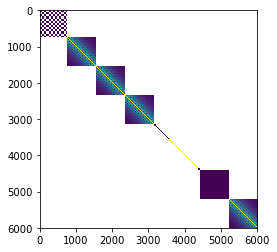

In [15]:
cov = cov.x
cov[cov==0] = np.NaN
plt.imshow(cov)